In [96]:
library(readr)
library(dplyr)
library("ROCR")

In [82]:
Total <- read_csv('Total_data.csv')
Expert <- read_csv('Expert_data.csv')

print('Total');glimpse(Total)
print('Expert');glimpse(Expert)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  `Offering Course Code` = col_character(),
  Role = col_character(),
  `Created At` = col_datetime(format = ""),
  `Week Of Semester` = col_character(),
  `Moderator Experiment Group` = col_character(),
  `Resource Type` = col_character(),
  `Final Comment` = col_character(),
  `First Comment` = col_character(),
  Flagged = col_logical(),
  `Flagged - Similarity` = col_logical(),
  `Flagged - Relatedness` = col_logical(),
  `Flagged - Suggestion` = col_logical(),
  `Checkbox 1` = col_logical(),
  `Checkbox 2` = col_logical(),
  `Checkbox 3` = col_logical(),
  `Checkbox 4` = col_logical(),
  `Author Experiment Group` = col_character(),
  ResModID = col_character()
)
See spec(...) for full column specifications.
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  `Offering Course Code` = 

[1] "Total"
Observations: 60,622
Variables: 40
$ X1                              <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...
$ Resource_ID                     <dbl> 80964, 80948, 80968, 80945, 80948, ...
$ User_ID                         <dbl> 26258, 26258, 26258, 27993, 27993, ...
$ `Offering ID`                   <dbl> 733, 733, 733, 733, 733, 733, 733, ...
$ `Offering Course Code`          <chr> "MEDI", "MEDI", "MEDI", "MEDI", "ME...
$ Role                            <chr> "student", "student", "student", "s...
$ `Created At`                    <dttm> 2021-07-27 20:32:12, 2021-07-27 20...
$ `Week Of Semester`              <chr> "Week 0", "Week 0", "Week 0", "Week...
$ `Moderator Experiment Group`    <chr> "oversight", "oversight", "oversigh...
$ `Time to Complete`              <dbl> 49260, 70298, 43122, 73897, 60207, ...
$ `Resource Type`                 <chr> "MCQ", "MCQ", "MCQ", "MCQ", "MCQ", ...
$ R1                              <dbl> 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,...
$ R2 

In [83]:
table(Total$`Offering Course Code`)
table(Expert$`Offering Course Code`)


 AGRC  ANIM  COMP  CRIM  ECON  INFS  MEDI  NEUR  NUTR  PHRM 
11462   666  3543  2492  4510  4951  6467 20939  3051  2541 


AGRC ANIM COMP CRIM ECON INFS MEDI NEUR NUTR PHRM 
 226   46   59   12  303   31   27  255   15   43 

In [86]:
################################################ Result evaluation function ################################################
results <- function(Mean_expert,Bias_Users,w=3){
# print('Cor')
x1=round(cor(Mean_expert,Bias_Users,method = "pearson"),2);
#     print(x1)

# print('RMSE')
x2=round(sqrt(mean((Mean_expert - Bias_Users)^2)),2);
#     print(x2)
Experts=ifelse(Mean_expert>=3,1,0)
Users=ifelse(Bias_Users>=w,1,0)
# print('AUC')
x3=round(as.double(performance(prediction(Users,Experts), 'auc')@y.values),2);
#     print(x3)
t=table(Users,Experts)
TN=t[1]
FP=t[2]
FN=t[3]
TP=t[4]
  
ACC=  round((TP+TN)/(TP + TN + FP + FN),2)
# print('sensitivity') ; 
    tpr=round(TP/(TP + FN),2);
#     print(tpr)
# print('specificity') ; 
    tnr=round(TN/(TN + FP),2);
#     print(tnr)

x=c(tpr,tnr,x3,ACC);
#     print(x)
write.table(t(c(x)), "clipboard", sep=" & ", row.names=FALSE, col.names=FALSE)
    return(c(x,x1,x2))
    }
################################################ reliability score function ################################################

scoreG <- function(x,a){    # reliability score function
     out <-  (2/(1+exp(-a*(x))))-1
    return(out)
    }
################################################ reward score function################################################
reward <- function(x,sigma,top){    # reward score function
     mu=0
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- top*(normal)
    return(out)
    }
################################################ punish score function################################################
punish <- function(x,sigma,top){    # punish score function
     mu=0
#     sigma= 0.5    #var(Total$Diff)/2=0.7502/2
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- top*(-normal0+normal)
    return(out)
    }
################################################ Resource Discrimination score function################################################
rdis <- function(x,eps,sigma){    # Resource Discrimination
     mu=0
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - 3 - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- (normal0-normal+eps)
    return(out)
    }
################################################ Trust score function ################################################

pntrust <- function(x,a){    # aprroved/reject score function
    out <-  (1/(.1+exp(-a*(x))))
   
    return(out)
    }
trust <- function(x,a){    # reliability score function
    out <-  (2/(1+exp(-a*(x))))-1
    return(out)
    }

In [89]:
c(
length(unique(Total$Resource_ID)),
length(unique(Total$User_ID)),
dim(Total)[1]
)

[1] 11481  2837 60622

In [90]:
c(
length(unique(Expert$Resource_ID)),
length(unique(Total$User_ID[Total$Resource_ID %in% Expert$Resource_ID])),
length((Total$User_ID[Total$Resource_ID %in% Expert$Resource_ID]))
)

[1] 1017 1602 5856

# Baselines

## Mean

In [92]:
Mean_Users=vector()
k=1
for (i in Expert$Resource_ID)
    {
    Mean_Users[k]=mean(Total$Decision[Total$Resource_ID==i])
    k=k+1
    }
results(Expert$Decision,Mean_Users,3)

[1] 0.99 0.10 0.55 0.70 0.58 1.08

In [93]:
mean=Mean_Users
expert=Expert$Decision
models=data.frame(expert,mean)



## Median

In [95]:
Mean_Users=vector()
k=1
for (i in Expert$Resource_ID)
    {
    Mean_Users[k]=median(Total$Decision[Total$Resource_ID==i])
    k=k+1
    }
results(Expert$Decision,Mean_Users,3)


[1] 1.00 0.06 0.53 0.69 0.39 1.22

## Current Model

In [66]:
initial=1000
score <- function(x){    # reliability score function
     mu=0
    sigma= .75     #var(Total$Diff)/2=0.7502/2
    normal <- 1/(sqrt(2 * pi) * sigma) * exp(-((x - mu)^2/(2* sigma^2)))
    normal0 <- 1/(sqrt(2 * pi) * sigma) * exp(-(( - mu)^2/(2* sigma^2)))
    out <- 100*(normal-normal0/2) # 
    return(out)
    }
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Moderating_Score=matrix(initial, nrow = length(Total_User_ID), ncol = 1)#initial
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
moderation_NEUR_current=matrix(nrow = dim(Total)[1], ncol = 3)
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                if(Moderating_Score[kk]>0)
                    {
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & 
                                         Total$Resource_ID==i])*
                                            Moderating_Score[kk]
                    wsum=wsum+Moderating_Score[kk]
                    }
            }
        rhat= rsum/wsum
        for (j in Total$User_ID[Total$Resource_ID==i] )
            {
                kk=match(j,Total_User_ID)
                Dr= rhat
                        ################ expert
                if(i %in% Expert$Resource_ID) {Dr=Expert$Decision[Expert$Resource_ID==i]}
                        ########################

                Moderating_Score[kk]=Moderating_Score[kk]+
                    score((Total$Decision[Total$User_ID==j & 
                                     Total$Resource_ID==i]-Dr))
             if(Moderating_Score[kk]<=0) Moderating_Score[kk]=1
      
        }
        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.98 0.18 0.58 0.72 0.59 1.07

In [67]:
write_csv(data.frame(Test_Data_Resource_ID,Users_Decision,Expert_Decision),'EM_out.csv')

In [68]:
results(Expert_Decision,Users_Decision)

[1] 0.98 0.18 0.58 0.72 0.59 1.07

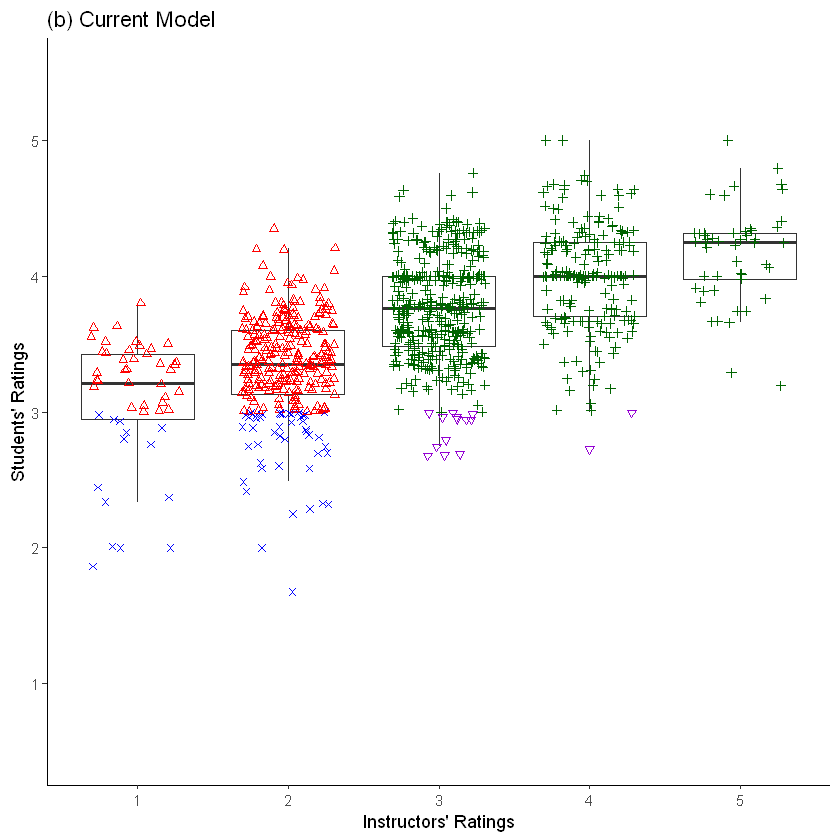

In [69]:
Decision=Users_Decision
expert=Expert_Decision
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx2=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab('Students\' Ratings')+ xlab('Instructors\' Ratings')+ ggtitle('(b) Current Model ')+
    geom_jitter(shape = Test$shape,
        color = Test$Colour,
        position = position_jitter(width = 0.31)) +
    theme_classic() 


bx2

# Graph model

In [85]:
q_id=unique(Total$Resource_ID)#[1:16]
glimpse(q_id)
print('expert')
# Expert=subset(Expert,Expert$Resource_ID %in% q_id)
expert1=Expert[,c('Resource_ID','Decision')]
glimpse(expert1)

moderations=subset(Total,Resource_ID %in% q_id)[,c('Resource_ID','User_ID','Decision')]
glimpse(moderations)

u_id=unique(moderations$User_ID)
glimpse(u_id)

 num [1:11481] 80964 80948 80968 80945 80963 ...
[1] "expert"
Observations: 1,017
Variables: 2
$ Resource_ID <dbl> 81138, 81910, 81634, 81617, 80862, 82704, 82701, 82693,...
$ Decision    <dbl> 2, 1, 2, 4, 2, 3, 3, 3, 3, 3, 2, 2, 4, 4, 3, 4, 3, 4, 2...
Observations: 60,622
Variables: 3
$ Resource_ID <dbl> 80964, 80948, 80968, 80945, 80948, 80963, 80957, 80964,...
$ User_ID     <dbl> 26258, 26258, 26258, 27993, 27993, 27993, 27993, 27993,...
$ Decision    <dbl> 4, 4, 4, 4, 4, 4, 2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5...
 num [1:2837] 26258 27993 28205 26543 29004 ...


In [80]:
##################################### Initializing #####################################
reward0=500 # Initial reward point
rel_teta=.001 # Relibility function coef
maxrew=100
tp=vector()
tn=vector()
auc=vector()
cor=vector()
rmse=vector()

    N=length(u_id)+1
    ##################################### Variables #####################################
    Pos=matrix(0,nrow=N ,ncol= 1 ) # Users' Positive Ratings
    Neg=matrix(0,nrow=N ,ncol= 1 ) # Users' Negative Ratings
    Rew=matrix(reward0,nrow=N ,ncol= 1 ) # Users' Rewards
    W=matrix(scoreG(reward0,rel_teta),nrow=N ,ncol= 1 ) # Users' Reliability
    W[N]=1
    Trust= diag(N) #matrix(0,nrow=N ,ncol= N ) 
    A=matrix(0,nrow=N ,ncol= N ) # agreements btw users
    D=matrix(0,nrow=N ,ncol= N ) # disagreements btw users
    WT = (Trust %*% W) # Weight based on reliability and others Trust
    RA=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of agreements on Rj
    RD=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of disagreements on Rj
    Rhat=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatT=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatN=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    RhatW=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    
    
    kq=1
    for(i in q_id)
        {
        B= Trust %*% Trust
        tau=quantile(B[1:N-1,N],names = FALSE)[1]
        tauWT=quantile(WT,names = FALSE)[1]
        tauW=quantile(W,names = FALSE)[1]
        users=moderations$User_ID[moderations$Resource_ID==i]
        n=length(users)
        si=0
        wi=0
        Win= matrix(1,nrow= n,ncol=1) # collecting user reliability
        exclude= matrix(1,nrow= N,ncol=1) # removing those moderated this resource for trust propagation and keeping others
        exclude[N]=0
        for(j in 1:(n-1))
            {
            kj=match(users[j],u_id)
            exclude[kj]=0
            Win[j]=W[kj]
            Dj=moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            if (W[kj]>tauW & WT[kj]>tauWT &  B[kj,N]>=tau) 
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj]); wi=wi+(PNj*W[kj])
                                RhatN[kq]= RhatN[kq]+1 # number of decisions
                                RhatW[kq]= wi # number of decisions

            }                                                                               ########################## DECISION
            for(l in users[(j+1):n])
                {
                kl=match(l,u_id)
                Dl=moderations$Decision[moderations$User_ID==l & moderations$Resource_ID==i]
                if ((Dl>= 3 &  Dj>=3) | (Dl< 3 &  Dj<3)) 
                {
                    A[kj,kl]= A[kj,kl]+1;A[kl,kj]= A[kl,kj]+1;
                    RA[kq]=RA[kq]+1
                } 
                else 
                {
                    D[kj,kl]= D[kj,kl]+1;D[kl,kj]= D[kl,kj]+1;
                    RD[kq]=RD[kq]+1
                }
            }
            if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            }
        }
        ########################### inferred decision on R
        kj=match(users[n],u_id)
        exclude[kj]=0
        Dj=moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID==i]
        Win[n]=W[kj]
        if (W[kj]>tauW & WT[kj]>tauWT & B[kj,N]>=tau)
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                 if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj]); wi=wi+(PNj*W[kj])
                            RhatN[kq]= RhatN[kq]+1 # number of decisions
                            RhatW[kq]= wi # weight of decisions

            }  # If Reliability User >0 AND sum trust*Relibility other users >0 ########################## DECISION
      
        Rhat[kq] = si/wi # inferred decision on R 
        RhatT[kq] = si/wi # inferred decision on R based on Users
        if(wi==0)
            {
            Rhat[kq] = 0
        RhatT[kq] = 0
        }
        Eimpact = max(Win) # no expert
        if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            Rhat[kq] = Ej
#             Eimpact = 1 # expert
            }
        Trust=trust((A-D),1) # Update trusts btw users
        ########################### update user reliability
        GRew=matrix(0,nrow=N ,ncol= 1 ) # Users' Gained Rewards
        TC=matrix(0,nrow=N ,ncol= 1 ) # Connected Users
        for(j in 1:n)
            {
            
            kj = match(users[j],u_id)
            TC=TC+abs(Trust[,kj])
            Dj = moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            Dl = Rhat[kq]
            if ((Dl>= 3 &  Dj>=3) ) 
                {
                
                point= 
                reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            if ( (Dl< 3 &  Dj<3)) 
                {
                
                point= 
                 reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            
            if ((Dl>= 3 &  Dj<3) ) 
                {
                point= 
                punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            if ((Dl< 3 &  Dj>=3) ) 
                {
                point= 
                 punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            GRew[kj] =  point
        }
        ########################### Propagation
        others=exclude*c(u_id,1) # Remove current moderators
        others[TC==0]=0 # Remove unconnected users
        for (uc in others[others!=0]) # only connected users outside the supernode
            {
            kuc=match(uc,u_id)
            relmax=W[kuc]
            Tmax=0
            for (um in users)
                {
                kum=match(um,u_id)
                if (Trust[kuc,kum]!=0)
                    {
                    if (W[kum]>relmax)
                        {
                        relmax=W[kum]
                        beta=.5
                        if (i %in% Expert$Resource_ID)
                        {
                            beta=1
                        }
                        GRew[kuc] =  GRew[kum] * Trust[kuc,kum] *beta
                        Tmax = abs(GRew[kuc])
                    }
                    if (W[kum]==relmax)
                        {
                        if (abs(GRew[kum] * Trust[kuc,kum])> Tmax)
                            {
                            relmax=W[kum]
                             beta=.5
                            if (i %in% Expert$Resource_ID)
                            {
                                beta=1
                            }
                            GRew[kuc] =  GRew[kum] * Trust[kuc,kum]* beta
                            Tmax = abs(GRew[kuc])
                        } 
                    }
                }
            }
            
            
        }
        if (i %in% Expert$Resource_ID)
            {
            others=exclude*c(u_id,1) # Remove current moderators
            GRew[N]=reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) 
            beta=1
            for (uc in others[others!=0]) # only connected users outside the supernode
                {
                kuc=match(uc,u_id)
                if (Trust[kuc,N]!=0)
                    {
                    GRew[kuc] =  GRew[N] * Trust[kuc,N]* beta
                    }
                
            }                  
        }

        Rew = Rew + GRew
        W = scoreG(Rew,rel_teta) # update user reliability
        W[N]=1 # Expert
        WT =  (Trust %*% W)
        kq=kq+1    
    }
    ##################################### Evaluation #####################################

RQ=data.frame(q_id,RhatT)
    inferred=vector()
    k=1
    for (i in Expert$Resource_ID)
        {
        inferred[k]=RQ$RhatT[RQ$q_id==i]
        k=k+1
    }
results(Expert$Decision,inferred,3)

[1] 0.86 0.67 0.77 0.80 0.08 3.79

In [81]:
write_csv(data.frame(Expert$Resource_ID,inferred,Expert$Decision),'Graph_moderation_out.csv')

In [82]:
results(Expert$Decision,inferred,3)

[1] 0.86 0.67 0.77 0.80 0.08 3.79

In [20]:
NEUR2$graph=inferred

# Length

In [73]:

Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (Total$`Comment Length`[Total$User_ID==j &Total$Resource_ID==i])
                    wsum=wsum+(Total$`Comment Length`[Total$User_ID==j &Total$Resource_ID==i])
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.95 0.38 0.66 0.76 0.58 1.01

In [76]:
results(Expert_Decision,Users_Decision)#100

[1] 0.95 0.38 0.66 0.76 0.58 1.01

In [75]:
models$length=Users_Decision

# BERT

In [75]:
glimpse(Total)

Rows: 70,970
Columns: 39
$ Resource_ID                     <dbl> 80964, 80948, 80968, 80945, 80948, ...
$ User_ID                         <dbl> 26258, 26258, 26258, 27993, 27993, ...
$ `Offering ID`                   <dbl> 733, 733, 733, 733, 733, 733, 733, ...
$ `Offering Course Code`          <chr> "MEDI", "MEDI", "MEDI", "MEDI", "ME...
$ Role                            <chr> "student", "student", "student", "s...
$ `Created At`                    <dttm> 2021-07-27 20:32:12, 2021-07-27 20...
$ `Week Of Semester`              <chr> "Week 0", "Week 0", "Week 0", "Week...
$ `Moderator Experiment Group`    <chr> "oversight", "oversight", "oversigh...
$ `Time to Complete`              <dbl> 49260, 70298, 43122, 73897, 60207, ...
$ `Resource Type`                 <chr> "MCQ", "MCQ", "MCQ", "MCQ", "MCQ", ...
$ R1                              <dbl> 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,...
$ R2                              <dbl> 4, 4, 4, 5, 4, 4, 2, 4, 4, 5, 5, 5,...
$ R3                       

In [77]:
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (1+100*abs(Total$`Relatedness Score`[Total$User_ID==j &Total$Resource_ID==i]))
                    wsum=wsum+(1+100*abs(Total$`Relatedness Score`[Total$User_ID==j &Total$Resource_ID==i]))
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.97 0.27 0.62 0.74 0.56 1.06

# Length x BERT

In [78]:
Total_User_ID=unique(Total$User_ID)
Total_Resource_ID=unique(Total$Resource_ID)
############## Reliabity calculation
Resource_Quality=matrix(nrow = length(Total_Resource_ID), ncol = 1)
kr=1
for(i in Total_Resource_ID)
    {

        wsum=0;
        rsum=0

            for (j in Total$User_ID[Total$Resource_ID==i] )
            {
             
                    rsum= rsum+ (Total$Decision[Total$User_ID==j & Total$Resource_ID==i])*
                                            (Total$`Comment Length`[Total$User_ID==j &Total$Resource_ID==i])*
                                            (1+100*abs(Total$`Relatedness Score`[Total$User_ID==j &Total$Resource_ID==i]))
                    wsum=wsum+(Total$`Comment Length`[Total$User_ID==j &Total$Resource_ID==i])*
                                            (1+100*abs(Total$`Relatedness Score`[Total$User_ID==j &Total$Resource_ID==i]))
                    
            }
        rhat= rsum/wsum

        Resource_Quality[kr]=rhat
kr=kr+1
    }
####################################
RQ=data.frame(Resource_Quality)
RQ$Resource_ID =Total_Resource_ID

############################################ Evaluation

Test_Data_Resource_ID=unique(Expert$Resource_ID)
Test_Data_Users_Decision=matrix(0, nrow = length(Test_Data_Resource_ID), ncol = 3)
k=1
for (i in Test_Data_Resource_ID)
    {
    Test_Data_Users_Decision[k,1]=i
    Test_Data_Users_Decision[k,2]=Expert$Decision[Expert$Resource_ID==i]
    Test_Data_Users_Decision[k,3]=RQ$Resource_Quality[RQ$Resource_ID==i]
   k=k+1
    }
########################################################################
Expert_Decision=Test_Data_Users_Decision[,2]
Users_Decision=Test_Data_Users_Decision[,3]
results(Expert_Decision,Users_Decision)

[1] 0.92 0.43 0.68 0.76 0.55 1.02

In [79]:
models$Lbert=Users_Decision

# Graph with Length X BERT

In [83]:
moderations=Total
##################################### Initializing #####################################
reward0=500 # Initial reward point
rel_teta=.001 # Relibility function coef
maxrew=100
tp=vector()
tn=vector()
auc=vector()
cor=vector()
rmse=vector()

    N=length(u_id)+1
    ##################################### Variables #####################################
    Pos=matrix(0,nrow=N ,ncol= 1 ) # Users' Positive Ratings
    Neg=matrix(0,nrow=N ,ncol= 1 ) # Users' Negative Ratings
    Rew=matrix(reward0,nrow=N ,ncol= 1 ) # Users' Rewards
    W=matrix(scoreG(reward0,rel_teta),nrow=N ,ncol= 1 ) # Users' Reliability
    W[N]=1
    Trust= diag(N) #matrix(0,nrow=N ,ncol= N ) 
    A=matrix(0,nrow=N ,ncol= N ) # agreements btw users
    D=matrix(0,nrow=N ,ncol= N ) # disagreements btw users
    WT = (Trust %*% W) # Weight based on reliability and others Trust
    RA=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of agreements on Rj
    RD=matrix(0,nrow=length(q_id) ,ncol= 1 ) # number of disagreements on Rj
    Rhat=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatT=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Inferred Decision on Rj
    RhatN=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    RhatW=matrix(0,nrow=length(q_id) ,ncol= 1 ) # Number of Decision on Rj
    
    
    kq=1
    for(i in q_id)
        {
        B= Trust %*% Trust
        tau=quantile(B[1:N-1,N],names = FALSE)[1]
        tauWT=quantile(WT,names = FALSE)[1]
        tauW=quantile(W,names = FALSE)[1]
        users=moderations$User_ID[moderations$Resource_ID==i]
        n=length(users)
        si=0
        wi=0
        Win= matrix(1,nrow= n,ncol=1) # collecting user reliability
        exclude= matrix(1,nrow= N,ncol=1) # removing those moderated this resource for trust propagation and keeping others
        exclude[N]=0
        for(j in 1:(n-1))
            {
            kj=match(users[j],u_id)
            exclude[kj]=0
            Win[j]=W[kj]
            Dj=moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            if (W[kj]>tauW & WT[kj]>tauWT &  B[kj,N]>=tau) 
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj])* 
                (moderations$`Comment Length`[moderations$User_ID==users[j] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$`Relatedness Score`[moderations$User_ID==users[j] &moderations$Resource_ID==i]))
                wi=wi+(PNj*W[kj])* 
                (moderations$`Comment Length`[moderations$User_ID==users[j] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$`Relatedness Score`[moderations$User_ID==users[j] &moderations$Resource_ID==i]))
                                RhatN[kq]= RhatN[kq]+1 # number of decisions
                                RhatW[kq]= wi # number of decisions

            }                                                                               ########################## DECISION
            for(l in users[(j+1):n])
                {
                kl=match(l,u_id)
                Dl=moderations$Decision[moderations$User_ID==l & moderations$Resource_ID==i]
                if ((Dl>= 3 &  Dj>=3) | (Dl< 3 &  Dj<3)) 
                {
                    A[kj,kl]= A[kj,kl]+1;A[kl,kj]= A[kl,kj]+1;
                    RA[kq]=RA[kq]+1
                } 
                else 
                {
                    D[kj,kl]= D[kj,kl]+1;D[kl,kj]= D[kl,kj]+1;
                    RD[kq]=RD[kq]+1
                }
            }
            if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            }
        }
        ########################### inferred decision on R
        kj=match(users[n],u_id)
        exclude[kj]=0
        Dj=moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID==i]
        Win[n]=W[kj]
        if (W[kj]>tauW & WT[kj]>tauWT & B[kj,N]>=tau)
            {
#                 neg=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]<3)
#                 pos=sum(moderations$Decision[moderations$User_ID==users[n] & moderations$Resource_ID %in% q_id [1:kq]]>=3)
                 if (Dj<3) {Neg[kj]= Neg[kj]+1; PN=(Pos[kj]+Neg[kj])/Neg[kj]}
                if (Dj>=3) {Pos[kj]= Pos[kj]+1;PN=(Pos[kj]+Neg[kj])/Pos[kj]}
                
                PNj=pntrust(PN,.5) 
                si=si+Dj*(PNj*W[kj])* 
                (moderations$`Comment Length`[moderations$User_ID==users[n] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$`Relatedness Score`[moderations$User_ID==users[n] & moderations$Resource_ID==i]))
                wi=wi+(PNj*W[kj])* 
                (moderations$`Comment Length`[moderations$User_ID==users[n] & moderations$Resource_ID==i])*
                    (1+100*abs(moderations$`Relatedness Score`[moderations$User_ID==users[n] & moderations$Resource_ID==i]))
                            RhatN[kq]= RhatN[kq]+1 # number of decisions
                            RhatW[kq]= wi # weight of decisions

            }  # If Reliability User >0 AND sum trust*Relibility other users >0 ########################## DECISION
      
        Rhat[kq] = si/wi # inferred decision on R 
        RhatT[kq] = si/wi # inferred decision on R based on Users
        if(wi==0)
            {
            Rhat[kq] = 0
        RhatT[kq] = 0
        }
        Eimpact = max(Win) # no expert
        if (i %in% Expert$Resource_ID)
                {
                Ej=Expert$Decision[Expert$Resource_ID==i]
                if ((Ej>= 3 &  Dj>=3) )
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                if ( (Ej< 3 &  Dj<3))
                    {
                    A[kj,N]= A[kj,N]+1;A[N,kj]= A[N,kj]+1;
                } 
                
                if ((Ej>= 3 &  Dj<3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
                if ((Ej< 3 &  Dj>=3) ) 
                    {
                    D[kj,N]= D[kj,N]+1;D[N,kj]= D[N,kj]+1;
                }
            Rhat[kq] = Ej
#             Eimpact = 1 # expert
            }
        Trust=trust((A-D),1) # Update trusts btw users
        ########################### update user reliability
        GRew=matrix(0,nrow=N ,ncol= 1 ) # Users' Gained Rewards
        TC=matrix(0,nrow=N ,ncol= 1 ) # Connected Users
        for(j in 1:n)
            {
            
            kj = match(users[j],u_id)
            TC=TC+abs(Trust[,kj])
            Dj = moderations$Decision[moderations$User_ID==users[j] & moderations$Resource_ID==i]
            Dl = Rhat[kq]
            if ((Dl>= 3 &  Dj>=3) ) 
                {
                
                point= 
                reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            if ( (Dl< 3 &  Dj<3)) 
                {
                
                point= 
                 reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Gain rewards * Resoource Discrimination
                
                } 
            
            if ((Dl>= 3 &  Dj<3) ) 
                {
                point= 
                punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            if ((Dl< 3 &  Dj>=3) ) 
                {
                point= 
                 punish(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) # Recieve Punishment * Resource Discrimination
                }
            GRew[kj] =  point
        }
        ########################### Propagation
        others=exclude*c(u_id,1) # Remove current moderators
        others[TC==0]=0 # Remove unconnected users
        for (uc in others[others!=0]) # only connected users outside the supernode
            {
            kuc=match(uc,u_id)
            relmax=W[kuc]
            Tmax=0
            for (um in users)
                {
                kum=match(um,u_id)
                if (Trust[kuc,kum]!=0)
                    {
                    if (W[kum]>relmax)
                        {
                        relmax=W[kum]
                        beta=.5
                        if (i %in% Expert$Resource_ID)
                        {
                            beta=1
                        }
                        GRew[kuc] =  GRew[kum] * Trust[kuc,kum] *beta
                        Tmax = abs(GRew[kuc])
                    }
                    if (W[kum]==relmax)
                        {
                        if (abs(GRew[kum] * Trust[kuc,kum])> Tmax)
                            {
                            relmax=W[kum]
                             beta=.5
                            if (i %in% Expert$Resource_ID)
                            {
                                beta=1
                            }
                            GRew[kuc] =  GRew[kum] * Trust[kuc,kum]* beta
                            Tmax = abs(GRew[kuc])
                        } 
                    }
                }
            }
            
            
        }
        if (i %in% Expert$Resource_ID)
            {
            others=exclude*c(u_id,1) # Remove current moderators
            GRew[N]=reward(Dl-Dj,1,Eimpact*maxrew) * rdis(Dl,.1,.445) 
            beta=1
            for (uc in others[others!=0]) # only connected users outside the supernode
                {
                kuc=match(uc,u_id)
                if (Trust[kuc,N]!=0)
                    {
                    GRew[kuc] =  GRew[N] * Trust[kuc,N]* beta
                    }
                
            }                  
        }

        Rew = Rew + GRew
        W = scoreG(Rew,rel_teta) # update user reliability
        W[N]=1 # Expert
        WT =  (Trust %*% W)
        kq=kq+1    
    }
    ##################################### Evaluation #####################################

RQ=data.frame(q_id,RhatT)
    inferred=vector()
    k=1
    for (i in Expert$Resource_ID)
        {
        inferred[k]=RQ$RhatT[RQ$q_id==i]
        k=k+1
    }
results(Expert$Decision,inferred,3)

Warning message in close.connection(file):
"unable to open the clipboard"

[1] 0.85 0.74 0.80 0.82 0.12 4.72

In [84]:
write_csv(data.frame(Expert$Resource_ID,inferred,Expert$Decision),'GraphLbert_out_moderation.csv')

In [85]:
models$Gbert=inferred

In [86]:
write.csv(models,'models_outcomes.csv', row.names=FALSE)

In [34]:
models=read.csv('models_outcomes.csv')
em=read.csv('EM_out.csv')
models$em=em$ Users_Decision
glimpse(models)
glimpse(em)

Rows: 1,017
Columns: 6
$ expert <int> 2, 1, 2, 4, 2, 3, 3, 3, 3, 3, 2, 2, 4, 4, 3, 4, 3, 4, 2, 3, ...
$ mean   <dbl> 3.571429, 3.333333, 3.333333, 3.550000, 3.666667, 4.200000, ...
$ length <dbl> 3.438849, 3.000000, 2.162500, 3.440520, 3.635220, 4.267640, ...
$ Lbert  <dbl> 3.662691, 3.860397, 2.480609, 3.500622, 3.645031, 4.178507, ...
$ Gbert  <dbl> 2.757356, 3.860834, 2.513877, 3.500622, 1.696796, 4.176579, ...
$ em     <dbl> 3.566862, 3.346757, 3.332143, 3.550000, 3.614186, 4.213739, ...
Rows: 1,017
Columns: 3
$ Test_Data_Resource_ID <int> 81138, 81910, 81634, 81617, 80862, 82704, 827...
$ Users_Decision        <dbl> 3.566862, 3.346757, 3.332143, 3.550000, 3.614...
$ Expert_Decision       <int> 2, 1, 2, 4, 2, 3, 3, 3, 3, 3, 2, 2, 4, 4, 3, ...


In [23]:
results(models$expert ,models$Gbert  ,3)

[1] 0.86 0.74 0.80 0.82 0.12 4.72

Warning message:
"Removed 19 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing missing values (geom_rect)."Warning message:
"Removed 19 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 1 rows containing missing values (geom_rect)."

png 
  2

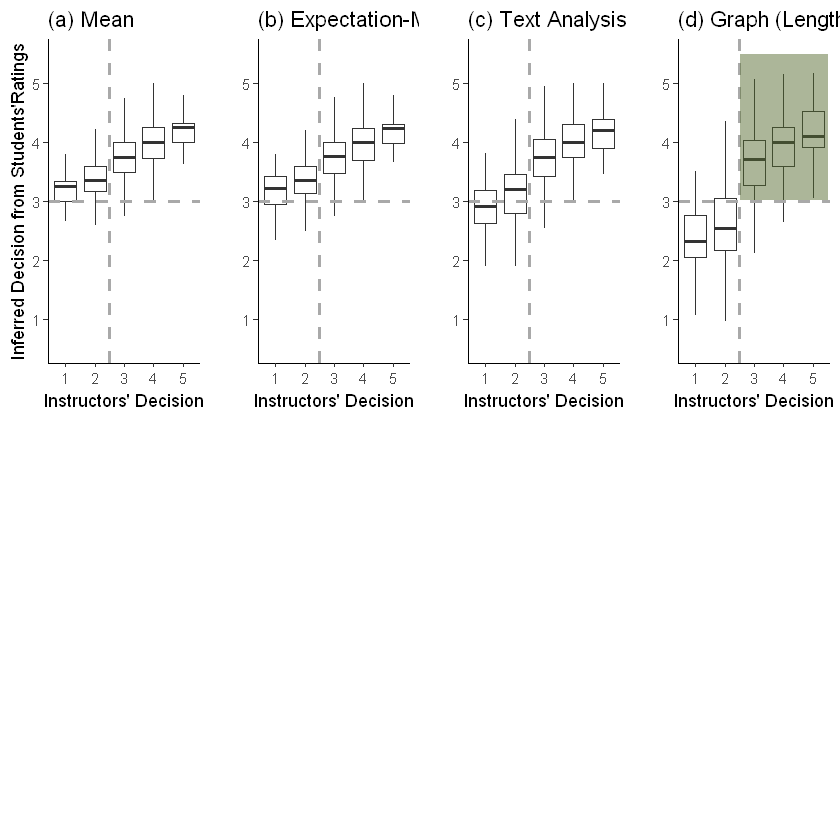

In [58]:
Decision=models$mean
expert=models$expert
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx1=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab('Inferred Decision from Students\'Ratings')+ xlab('Instructors\' Decision')+ ggtitle('(a) Mean ')+
#     geom_jitter(shape = Test$shape,
#         color = Test$Colour,
#         position = position_jitter(width = 0.31)) +
    theme_classic() +
geom_vline(xintercept = 2.5, linetype="dashed", 
                color = "darkgrey",size=1)+ 
geom_hline(yintercept = 3, linetype="dashed", 
                color = "darkgrey",size=1)
################################
Decision=models$em
expert=models$expert
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx2=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab('')+ xlab('Instructors\' Decision')+ ggtitle('(b) Expectation-Maximisation ')+
#     geom_jitter(shape = Test$shape,
#         color = Test$Colour,
#         position = position_jitter(width = 0.31)) +
    theme_classic() +
geom_vline(xintercept = 2.5, linetype="dashed", 
                color = "darkgrey",size=1)+ 
geom_hline(yintercept = 3, linetype="dashed", 
                color = "darkgrey",size=1)
################################
Decision=models$length   
expert=models$expert
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx3=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab(' ')+ xlab('Instructors\' Decision')+ ggtitle('(c) Text Analysis (Length) ')+
#     geom_jitter(shape = Test$shape,
#         color = Test$Colour,
#         position = position_jitter(width = 0.31)) +
    theme_classic() +
geom_vline(xintercept = 2.5, linetype="dashed", 
                color = "darkgrey",size=1)+ 
geom_hline(yintercept = 3, linetype="dashed", 
                color = "darkgrey",size=1)
#################################
Decision=models$Gbert
expert=models$expert
Test=data.frame(Decision,expert)
Test$Colour="darkgreen"
Test$Colour[Test$Decision<3]="blue"

Test$shape=3
Test$shape[Test$Decision<3]=4
Test$shape[Test$Decision<3 & Test$expert>=3]=6
Test$shape[Test$Decision>=3 & Test$expert<3]=2
Test$class="tp"
Test$class[Test$expert<3 & Test$Decision<3]="tn"

Test$Colour[Test$expert>=3 & Test$Decision<3]="darkviolet"
Test$class[Test$expert>=3 & Test$Decision<3]="fn"


Test$Colour[Test$expert<3 & Test$Decision>=3]="red"
Test$class[Test$expert<3 & Test$Decision>=3]="fp"

y_p=5.5
library(ggplot2)
box_plot2 <- ggplot(Test, aes(x=as.factor(expert), y = Decision))
bx4=box_plot2 +
    geom_boxplot(outlier.colour = "white") +
    ylim(.5,y_p)+ ylab('')+ xlab('Instructors\' Decision')+ ggtitle('(d) Graph (LengthxBERT)')+
#     geom_jitter(shape = Test$shape,
#         color = Test$Colour,
#         position = position_jitter(width = 0.31)) +
    theme_classic()+
geom_vline(xintercept = 2.5, linetype="dashed", 
                color = "darkgrey",size=1)+ 
geom_hline(yintercept = 3, linetype="dashed", 
                color = "darkgrey",size=1)+
annotate("rect", xmin = 0.482, xmax = 2.48, ymin = 0.48, ymax = 2.98,
  alpha = .2,fill='blue')+
annotate("rect", xmin = 2.52, xmax = 5.52, ymin = 3.02, ymax = 5.5,
  alpha = .2,fill='darkolivegreen')+
annotate("rect", xmin = 2.52, xmax = 5.52, ymin = 3.02, ymax = 5.5,
  alpha = .2,fill='darkolivegreen')+
annotate("rect", xmin = 2.52, xmax = 5.52, ymin = 3.02, ymax = 5.5,
  alpha = .2,fill='darkolivegreen')

library("cowplot")
plot_grid(bx1,bx2,bx3,bx4,
          ncol = 4, nrow = 2)
pdf("models comparison.pdf", width=16, height=4)
plot_grid(bx1,bx2,bx3,bx4,
          ncol = 4, nrow = 1)
dev.off()
